<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Imports & Settings

Adapted from the excellent paper by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar:  
[Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks),  
Neural Information Processing Systems (NeurIPS), 2019.

- Last updated Date: April 24th 2020
- [Original code](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/timegan/) author: Jinsung Yoon (jsyoon0823@gmail.com)

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [47]:
sns.set_style('white')

# Experiment Path

In [48]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [49]:
experiment = 0

In [50]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [51]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

# Prepare Data

## Parameters

In [52]:
#seq_len = 24
n_seq = 1
batch_size = 1

In [53]:
tickers = ['BRK-B']

In [54]:
def select_data():
    df = pd.read_csv('BRKB30Min6M1.csv')

In [55]:
select_data()

In [56]:
df = pd.read_csv('BRKB30Min6M1.csv', index_col = 0)
# df = pd.concat([df['AdjClose'], axis=1)

In [57]:
df_new = df.copy()

In [58]:
#train test split

In [59]:
train_number = int(len(df_new) * 0.8)

In [60]:
#tscv = TimeSeriesSplit(n_splits = 2, test_size = test_number)

In [61]:
#for train_index, test_index in tscv.split(X):
    #X_train, X_test = X[train_index], X[test_index]

train, test = df_new[0:train_number], df_new[train_number:]
seq_len = len(test)

In [62]:
len(test)

473

## Plot Series

In [63]:
# axes = train.div(train.iloc[0]).plot(subplots=True,
#                                figsize=(14, 6),
#                                layout=(3, 2),
#                                title=tickers,
#                                legend=False,
#                                rot=0,
#                                lw=1, 
#                                color='k')
# for ax in axes.flatten():
#     ax.set_xlabel('')

# plt.suptitle('Normalized Price Series')
# plt.gcf().tight_layout()
# sns.despine();

## Correlation

In [64]:
# sns.clustermap(train.corr(),
#                annot=True,
#                fmt='.2f',
#                cmap=sns.diverging_palette(h_neg=20,
#                                           h_pos=220), center=0);

## Normalize Data

In [65]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train[['ThirtyMin']]).astype(np.float32)

## Create rolling window sequences

In [66]:
data = []
for i in range(len(train) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

## Create tf.data.Dataset

In [67]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

## Set up random series generator

In [68]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [69]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

In [70]:
#next(random_series)

# TimeGAN Components

The design of the TimeGAN components follows the author's sample code.

##  Network Parameters

In [71]:
hidden_dim = 24
num_layers = 3

## Set up logger

In [72]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

## Input place holders

In [73]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

## RNN block generator

We keep it very simple and use a very similar architecture for all four components. For a real-world application, they should be tailored to the data.

In [74]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

## Embedder & Recovery

In [75]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

## Generator & Discriminator

In [76]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

# TimeGAN Training

## Settings

In [77]:
train_steps = 10000
gamma = 1

## Generic Loss Functions

In [78]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

# Phase 1: Autoencoder Training

## Architecture

In [79]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [80]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 473, 1)]          0         
_________________________________________________________________
Embedder (Sequential)        (None, 473, 24)           9744      
_________________________________________________________________
Recovery (Sequential)        (None, 473, 1)            10825     
Total params: 20,569
Trainable params: 20,569
Non-trainable params: 0
_________________________________________________________________


In [81]:
plot_model(autoencoder,
           to_file=(results_path / 'autoencoder.png').as_posix(),
           show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Autoencoder Optimizer

In [82]:
autoencoder_optimizer = Adam()

## Autoencoder Training Step

In [83]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Autoencoder Training Loop

In [84]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 10000/10000 [48:45<00:00,  3.42it/s]


## Persist model

In [85]:
autoencoder.save(log_dir / 'autoencoder')

INFO:tensorflow:Assets written to: time_gan/experiment_00/autoencoder/assets


INFO:tensorflow:Assets written to: time_gan/experiment_00/autoencoder/assets


# Phase 2: Supervised training

## Define Optimizer

In [86]:
supervisor_optimizer = Adam()

## Train Step

In [87]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

## Training Loop

In [88]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 10000/10000 [24:17<00:00,  6.86it/s]


## Persist Model

In [89]:
# supervisor.save(log_dir / 'supervisor')

# Joint Training

## Generator

### Adversarial Architecture - Supervised

In [90]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [91]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 473, 1)]          0         
_________________________________________________________________
Generator (Sequential)       (None, 473, 24)           9744      
_________________________________________________________________
Supervisor (Sequential)      (None, 473, 24)           7800      
_________________________________________________________________
Discriminator (Sequential)   (None, 473, 1)            10825     
Total params: 28,369
Trainable params: 28,369
Non-trainable params: 0
_________________________________________________________________


In [92]:
plot_model(adversarial_supervised, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### Adversarial Architecture in Latent Space

In [93]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [94]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 473, 1)]          0         
_________________________________________________________________
Generator (Sequential)       (None, 473, 24)           9744      
_________________________________________________________________
Discriminator (Sequential)   (None, 473, 1)            10825     
Total params: 20,569
Trainable params: 20,569
Non-trainable params: 0
_________________________________________________________________


In [95]:
plot_model(adversarial_emb, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### Mean & Variance Loss

In [96]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [97]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 473, 1)]          0         
_________________________________________________________________
Generator (Sequential)       (None, 473, 24)           9744      
_________________________________________________________________
Supervisor (Sequential)      (None, 473, 24)           7800      
_________________________________________________________________
Recovery (Sequential)        (None, 473, 1)            10825     
Total params: 28,369
Trainable params: 28,369
Non-trainable params: 0
_________________________________________________________________


In [98]:
plot_model(synthetic_data, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [99]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture: Real Data

In [100]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [101]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 473, 1)]          0         
_________________________________________________________________
Embedder (Sequential)        (None, 473, 24)           9744      
_________________________________________________________________
Discriminator (Sequential)   (None, 473, 1)            10825     
Total params: 20,569
Trainable params: 20,569
Non-trainable params: 0
_________________________________________________________________


In [102]:
plot_model(discriminator_model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Optimizers

In [103]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## Generator Train Step

In [104]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

## Embedding Train Step

In [105]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [106]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [107]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

## Training Loop

In [108]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.2417 | g_loss_u: 0.5638 | g_loss_s: 0.0001 | g_loss_v: 0.2729 | e_loss_t0: 0.0379
 1,000 | d_loss: 0.9235 | g_loss_u: 1.3619 | g_loss_s: 0.0000 | g_loss_v: 0.0627 | e_loss_t0: 0.0031
 2,000 | d_loss: 0.5863 | g_loss_u: 1.8803 | g_loss_s: 0.0000 | g_loss_v: 0.0686 | e_loss_t0: 0.0036
 3,000 | d_loss: 0.1332 | g_loss_u: 3.9277 | g_loss_s: 0.0000 | g_loss_v: 0.2529 | e_loss_t0: 0.0106
 4,000 | d_loss: 1.8120 | g_loss_u: 1.3506 | g_loss_s: 0.0000 | g_loss_v: 0.0566 | e_loss_t0: 0.0038
 5,000 | d_loss: 2.4779 | g_loss_u: 1.6941 | g_loss_s: 0.0000 | g_loss_v: 0.0939 | e_loss_t0: 0.0013
 6,000 | d_loss: 1.0669 | g_loss_u: 2.0061 | g_loss_s: 0.0000 | g_loss_v: 0.1102 | e_loss_t0: 0.0018
 7,000 | d_loss: 1.4242 | g_loss_u: 1.5570 | g_loss_s: 0.0000 | g_loss_v: 0.0960 | e_loss_t0: 0.0060
 8,000 | d_loss: 2.1386 | g_loss_u: 2.8370 | g_loss_s: 0.0000 | g_loss_v: 0.0806 | e_loss_t0: 0.0051
 9,000 | d_loss: 1.1825 | g_loss_u: 2.9471 | g_loss_s: 0.0000 | g_loss_v: 0.1033 | e_loss_t

## Persist Synthetic Data Generator

In [65]:
synthetic_data.save(log_dir / 'synthetic_data')

INFO:tensorflow:Assets written to: time_gan/experiment_00/synthetic_data/assets


INFO:tensorflow:Assets written to: time_gan/experiment_00/synthetic_data/assets


In [66]:
#train_discriminator(X_, Z_)

# Generate Synthetic Data

In [67]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [68]:
len(generated_data)

6

In [69]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(768, 24, 6)

In [70]:
np.save(log_dir / 'generated_data.npy', generated_data)

## Rescale

In [71]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(768, 24, 6)

In [ ]:
#fit test set into our model

In [151]:
# data_test = []
# for i in range(len(test) - seq_len):
#     data_test.append(scaled_data[i:i + seq_len])

# n_windows = len(data_test)

In [109]:
data_test = []
for i in range(len(test)):
    data_test.append(scaled_data[i])

n_windows = len(data_test)

In [72]:
# def make_random_data():
#     while True:
#         yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [ ]:
# random_series = iter(tf.data.Dataset
#                      .from_generator(make_random_data, output_types=tf.float32)
#                      .batch(batch_size)
#                      .repeat())

In [ ]:
#synthetic_data.save(log_dir / 'synthetic_data_test')

In [110]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [111]:
len(generated_data)

473

In [112]:
generated_data

[<tf.Tensor: shape=(1, 473, 1), dtype=float32, numpy=
 array([[[0.3292874 ],
         [0.26330352],
         [0.21120039],
         [0.21068141],
         [0.21187866],
         [0.20656371],
         [0.20439589],
         [0.20311207],
         [0.20485395],
         [0.20656332],
         [0.2095016 ],
         [0.2126095 ],
         [0.21447477],
         [0.21678054],
         [0.2188184 ],
         [0.22175944],
         [0.22411838],
         [0.22482738],
         [0.22825786],
         [0.2295633 ],
         [0.23083177],
         [0.2326678 ],
         [0.2342807 ],
         [0.23476264],
         [0.23736143],
         [0.23783407],
         [0.23808125],
         [0.24021891],
         [0.24158156],
         [0.24194092],
         [0.24186751],
         [0.2431396 ],
         [0.24335498],
         [0.24553037],
         [0.24643466],
         [0.24643087],
         [0.24750382],
         [0.24796769],
         [0.24851823],
         [0.2487075 ],
         [0.2490317 ],
   

In [113]:
# generated_data = (scaler.inverse_transform(generated_data
#                                            .reshape(-1, n_seq))
#                   .reshape(-1, seq_len, n_seq))
# generated_data.shape
generated_data_re = (scaler.inverse_transform(generated_data[0][0]))
generated_data_re.shape

(473, 1)

In [114]:
generated_data_re

array([[288.4212617 ],
       [284.90827931],
       [282.13430857],
       [282.1066782 ],
       [282.17041972],
       [281.88745198],
       [281.7720372 ],
       [281.70368638],
       [281.7964244 ],
       [281.88743136],
       [282.04386488],
       [282.20932976],
       [282.30863662],
       [282.43139613],
       [282.53989142],
       [282.69647251],
       [282.82206264],
       [282.85980966],
       [283.04244872],
       [283.11194987],
       [283.17948355],
       [283.27723387],
       [283.36310476],
       [283.38876289],
       [283.52712259],
       [283.55228568],
       [283.56544557],
       [283.67925464],
       [283.75180221],
       [283.77093435],
       [283.76702636],
       [283.83475203],
       [283.84621893],
       [283.96203673],
       [284.01018123],
       [284.00997972],
       [284.06710322],
       [284.09179983],
       [284.12111049],
       [284.13118746],
       [284.14844732],
       [284.19708052],
       [284.2164094 ],
       [284

In [118]:
real = pd.DataFrame(test['ThirtyMin'])
synthetic_30min = pd.DataFrame(generated_data_re, index = real.index)
real['synthetic_30min'] = synthetic_30min
#result = pd.concat([real, synthetic_daily[0]], ignore_index = True, axis = 1)

In [123]:
real.to_csv('30mins_data.csv')

In [119]:
real

ThirtyMin  synthetic_30min
Date                                       
2022/1/26 13:30   312.3200       288.421262
2022/1/26 14:00   312.7700       284.908279
2022/1/26 14:30   310.4303       282.134309
2022/1/26 15:00   307.7400       282.106678
2022/1/26 15:30   309.1600       282.170420
...                    ...              ...
2022/3/18 13:30   341.1250       285.665441
2022/3/18 14:00   341.7900       285.616375
2022/3/18 14:30   341.6034       285.615245
2022/3/18 15:00   342.8200       285.521828
2022/3/18 15:30   342.5900       285.484554

[473 rows x 2 columns]

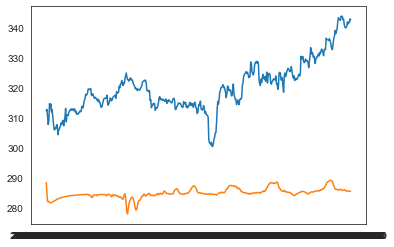

In [120]:
plt.plot(real)

<AxesSubplot:title={'center':'BRK-B'}, xlabel='Date'>

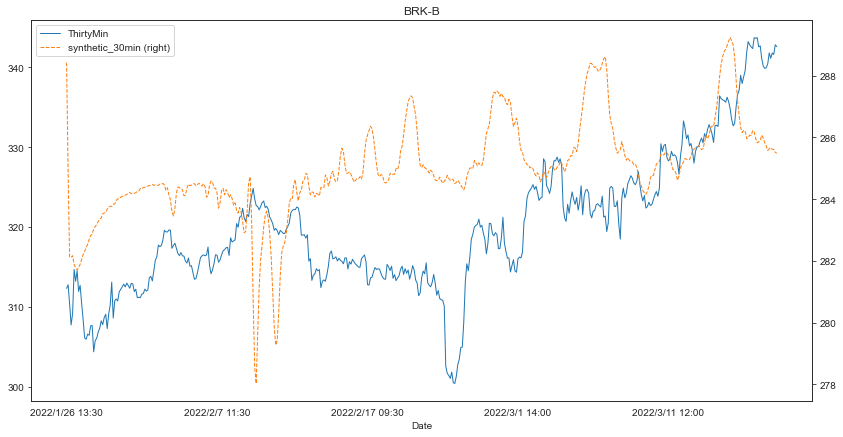

In [122]:
#dataframe = pd.DataFrame({'Real': real, 'Synthetic': synthetic})
real.plot(figsize=(14,7),title='BRK-B',secondary_y='synthetic_30min', style=['-', '--'],lw=1)

In [92]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(63504, 1)

In [88]:
synthetic = generated_data[np.random.randint(n_windows)]

In [89]:
synthetic

array([[0.46540022],
       [0.5155621 ],
       [0.52530986],
       [0.49243551],
       [0.5030369 ],
       [0.48077923],
       [0.4944472 ],
       [0.528596  ],
       [0.56413174],
       [0.5872887 ],
       [0.60045123],
       [0.60296315],
       [0.60133666],
       [0.5830174 ],
       [0.5406536 ],
       [0.49987754],
       [0.4690842 ],
       [0.46523362],
       [0.48505574],
       [0.5080216 ],
       [0.5295925 ],
       [0.53809196],
       [0.5123536 ],
       [0.47124678],
       [0.4442992 ],
       [0.4163819 ],
       [0.38894454],
       [0.3726768 ],
       [0.36227643],
       [0.35717747],
       [0.35522735],
       [0.35385418],
       [0.35458183],
       [0.35784373],
       [0.36123222],
       [0.36082292],
       [0.40162075],
       [0.4093    ],
       [0.41454515],
       [0.41881323],
       [0.41892472],
       [0.41215023],
       [0.41129905],
       [0.43611288],
       [0.4603021 ],
       [0.46473113],
       [0.45149612],
       [0.437

In [ ]:
np.save(log_dir / 'generated_data_test.npy', generated_data)

In [ ]:
len(test)


In [186]:
train

Open        High         Low       Close    AdjClose   Volume
Date                                                                          
2017/2/21  168.919998  169.649994  168.470001  168.919998  168.919998  4416900
2017/2/22  168.919998  169.699997  168.330002  169.610001  169.610001  3299400
2017/2/23  169.960007  170.160004  169.110001  170.149994  170.149994  3377100
2017/2/24  169.399994  170.279999  169.220001  170.220001  170.220001  4023400
2017/2/27  170.899994  171.199997  170.320007  170.630005  170.630005  3738600
...               ...         ...         ...         ...         ...      ...
2021/2/16  244.139999  247.259995  242.820007  245.279999  245.279999  4722200
2021/2/17  244.139999  246.190002  244.000000  245.250000  245.250000  3909500
2021/2/18  244.729996  245.490005  241.669998  243.500000  243.500000  4031000
2021/2/19  244.199997  244.949997  241.360001  241.850006  241.850006  4252400
2021/2/22  240.889999  245.979996  240.800003  244.970001  244.970001  4009100

[1008 rows x 6 columns]

In [189]:
returns = np.log(real['synthetic_daily']/real['synthetic_daily'].shift())
volatility = returns.std()*252**.5
returns

Date
2021/2/23         NaN
2021/2/24    0.029294
2021/2/25    0.002369
2021/2/26   -0.014370
2021/3/1     0.006084
               ...   
2022/2/14    0.003768
2022/2/15    0.006686
2022/2/16    0.005614
2022/2/17    0.002501
2022/2/18    0.006851
Name: synthetic_daily, Length: 252, dtype: float64

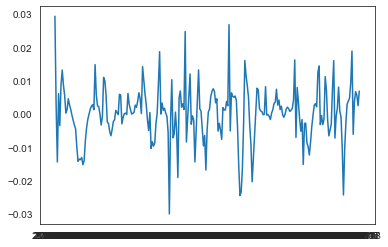

In [191]:
plt.plot(returns)

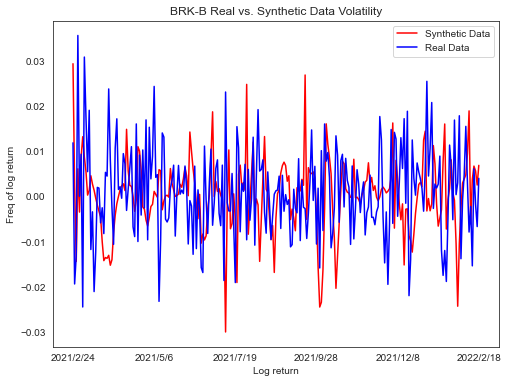

In [195]:
temp = np.log(real['AdjClose'] /real['AdjClose'].shift())
fig, ax = plt.subplots(figsize=(8,6))
returns[1:].plot(ax=ax, color='r',label = 'Synthetic Data')
temp[1:].plot(ax=ax, color='b',label = 'Real Data')
ax.set_xlabel('Log return')
ax.set_ylabel('Freq of log return')
ax.set_title('BRK-B Real vs. Synthetic Data Volatility')
ax.legend(['Synthetic Data','Real Data'])
plt.show()

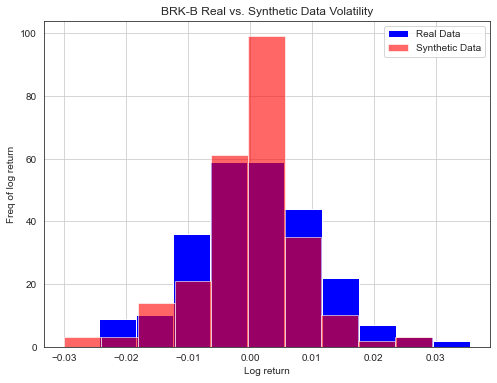

In [197]:
fig, ax = plt.subplots(figsize=(8,6))
temp[1:].hist(ax=ax, color='b', label = 'Real Data')
returns[1:].hist(ax=ax, alpha=0.6, color='r', label = 'Synthetic Data')
ax.set_xlabel('Log return')
ax.set_ylabel('Freq of log return')
ax.set_title('BRK-B Real vs. Synthetic Data Volatility')
plt.legend()
plt.show()